<a href="https://colab.research.google.com/github/ranton256/classifying_concord/blob/main/supervised_ML_identify_author.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Machine Learning - Identify Author


In [1]:
!pip install -q spacy

In [2]:
# you will need to download the spacy model for english.
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
!which python

/usr/local/bin/python


In [4]:
# %pip install -r requirements.txt

In [5]:
import spacy

## The Dataset
Our two datasets are constructed from two related works of 19th century American transcendentalism. These are both public domain.

1. [Essays by Ralph Waldo Emerson by Ralph Waldo Emerson](https://www.google.com/url?q=https%3A%2F%2Fwww.gutenberg.org%2Febooks%2F16643)
2. [Walden, and On The Duty Of Civil Disobedience by Henry David Thoreau](https://www.google.com/url?q=https%3A%2F%2Fwww.gutenberg.org%2Febooks%2F205)

These two authors had different writing styles but shared more than their philosophical interests—they were neighbors in Concord, Massachusetts.

These two works are also similar in length when formatted as plain text.

We will use spaCy to segment each work into sections of roughly 3 to 5 sentences each, then build a datafrom of the text including a label of 'emerson' or 'thoreau', then shuffle and split that into train and test sets for training some machine learning models to classify them by predicting which author they are from and compare the results.

We will also preprocess text to remove stopwords,and perform lemmatization.

In [6]:
emerson_txt_url = "https://www.gutenberg.org/ebooks/16643.txt.utf-8"
thoreau_txt_url = "https://www.gutenberg.org/ebooks/205.txt.utf-8"


In [7]:
import requests
from pathlib import Path

In [8]:
def download_file(url):
  local_filename = Path(url.split('/')[-1])
  result = requests.get(url)
  result.raise_for_status()
  with open(local_filename, "wb") as f:
      f.write(result.content)
  return local_filename

In [9]:
emerson_file = download_file(emerson_txt_url)
thoreau_file = download_file(thoreau_txt_url)

In [10]:
!head -n 50 {emerson_file}

﻿The Project Gutenberg eBook of Essays by Ralph Waldo Emerson
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Essays by Ralph Waldo Emerson

Author: Ralph Waldo Emerson

Editor: Edna Henry Lee Turpin

Release date: September 4, 2005 [eBook #16643]
                Most recently updated: April 29, 2022

Language: English

Credits: Curtis A. Weyant, Sankar Viswanathan and the Online Distributed Proofreading Team


*** START OF THE PROJECT GUTENBERG EBOOK ESSAYS BY RALPH WALDO EMERSON ***




                                ESSAYS

                                  BY

                    

In [11]:
!head -n 50 {thoreau_file}

﻿The Project Gutenberg eBook of Walden, and On The Duty Of Civil Disobedience
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Walden, and On The Duty Of Civil Disobedience

Author: Henry David Thoreau

Release date: January 1, 1995 [eBook #205]
                Most recently updated: September 19, 2024

Language: English

Credits: Judith Boss, and David Widger


*** START OF THE PROJECT GUTENBERG EBOOK WALDEN, AND ON THE DUTY OF CIVIL DISOBEDIENCE ***
WALDEN




and



ON THE DUTY OF CIVIL DISOBEDIENCE



by Henry David Thoreau


cover


Contents


 WALDEN

 Economy
 Where I Lived, and 

In [12]:
# Let's strip the frontmatter lines off the start of each file.
# remove each line preceding one that contains "START OF THE PROJECT GUTENBERG EBOOK "
!grep -n "START OF THE PROJECT GUTENBERG EBOOK" {emerson_file}
!grep -n "START OF THE PROJECT GUTENBERG EBOOK" {thoreau_file}

25:*** START OF THE PROJECT GUTENBERG EBOOK ESSAYS BY RALPH WALDO EMERSON ***
23:*** START OF THE PROJECT GUTENBERG EBOOK WALDEN, AND ON THE DUTY OF CIVIL DISOBEDIENCE ***


In [13]:
def trim_frontmatter(filename):
  with open(filename) as f:
    lines = f.readlines()

  n_trim_lines = 0
  for i, line in enumerate(lines):
    if "START OF THE PROJECT GUTENBERG EBOOK" in line:
      n_trim_lines = i + 1
      break

  trimmed_lines = lines[n_trim_lines:]
  trimmed_content = '\n'.join(trimmed_lines)
  new_filename = f"trimmed_{filename}"
  with open(new_filename, "w") as f:
    f.write(trimmed_content)
  return new_filename

In [14]:
trimmed_emerson_file = trim_frontmatter(emerson_file)
trimmed_thoreau_file = trim_frontmatter(thoreau_file)

In [15]:
!head {trimmed_emerson_file}
!head {trimmed_thoreau_file}









                                ESSAYS

WALDEN











In [16]:
from collections import deque
from random import randint
import itertools


In [17]:
nlp = spacy.load("en_core_web_sm")
# if you have an error here, make sure you ran the "!python -m spacy download en_core_web_sm" command in the earlier cell.

In [18]:
def segment_doc(filename):
  with open(filename) as f:
    text = f.read()
  doc = nlp(text)
  assert doc.has_annotation("SENT_START")

  sent_dq = deque()
  #it = doc.sents.__iter__()
  n = randint(3, 5)

  for sent in doc.sents:
    sent_dq.append(sent)
    if len(sent_dq) > n:
      sent_dq.popleft()
      snippet = " ".join(sent.text for sent in sent_dq)
      yield snippet
      n = randint(3, 5)
      sent_dq.clear()

In [19]:
import pandas as pd

In [20]:
def dataframe_from_file(file_path):
  segments = segment_doc(file_path)

  df = pd.DataFrame(segments, columns=["text"])
  return df


In [21]:
emerson_df = dataframe_from_file(trimmed_emerson_file)
emerson_df.to_csv("emerson.csv")
emerson_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071 entries, 0 to 1070
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1071 non-null   object
dtypes: object(1)
memory usage: 8.5+ KB


In [22]:
emerson_df.head()

,text
0,The editors of the several volumes will be\n\n...
1,"As a school-boy he was quiet and retiring, rea..."
2,"He was always serene and\n\nthoughtful, impres..."
3,His talent seems to have been in\n\ngiving new...
4,"To tell the truth, in my\n\nopinion, that youn..."


In [23]:

thoreau_df = dataframe_from_file(trimmed_thoreau_file)
thoreau_df.to_csv("thoreau.csv")
thoreau_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    848 non-null    object
dtypes: object(1)
memory usage: 6.8+ KB


In [24]:
thoreau_df.head()

,text
0,I lived there two\n\nyears and two months. At ...
1,Others have been\n\ncurious to learn what port...
2,"Moreover, I, on my side, require of every writ..."
3,I have travelled a good deal in Concord;\n\nan...
4,Better if they had been born in the\n\nopen pa...


In [25]:
# combine and shuffle the datasets, using a consistent random seed.
from sklearn.utils import shuffle

d1 = emerson_df.copy()
d1["label"] = "emerson"

d2 = thoreau_df.copy()
d2["label"] = "thoreau"

combined_df = pd.concat([d1, d2])
combined_df = shuffle(combined_df, random_state=7919)
combined_df.to_csv("combined.csv")
combined_df.info()
combined_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1919 entries, 151 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1919 non-null   object
 1   label   1919 non-null   object
dtypes: object(2)
memory usage: 45.0+ KB


,text,label
151,I look\n\nupon England to-day as an old gentle...,thoreau
638,Let us suck the sweetness of those affections ...,emerson
63,From the cave we have advanced to roofs of\n\n...,thoreau
409,"The result is now in question,\n\nalthough our...",emerson
35,"The soil, it appears, is suited to the seed, f...",thoreau


## Now we have our dataset in combined.csv


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# you can start here if csv files were already created.
from sklearn.feature_extraction.text import TfidfVectorizer

<ipython-input-28-33f8a76ce336>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=combined_df["label"], palette="rocket")


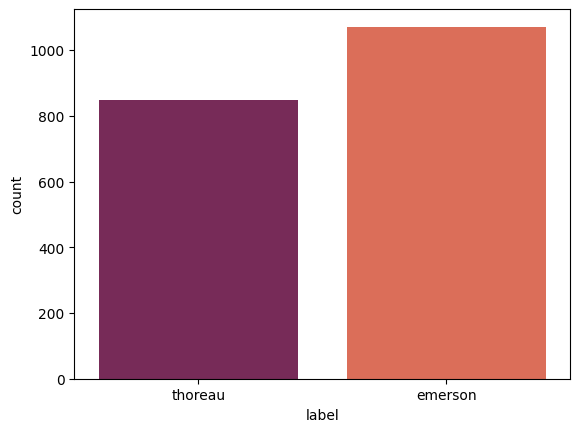

In [28]:
sns.countplot(x=combined_df["label"], palette="rocket")
plt.show()


In [29]:
%pip install -q wordcloud

In [30]:
from spacy.lang.en import STOP_WORDS
my_stopwords = STOP_WORDS

', '.join(my_stopwords)

"anyway, hereafter, nevertheless, front, onto, not, how, besides, ‘d, except, about, am, did, whither, sixty, twenty, elsewhere, re, seemed, more, call, what, yourselves, just, without, ’re, really, else, least, his, anything, upon, if, ever, before, whose, our, yours, these, meanwhile, us, afterwards, which, he, up, rather, most, been, amount, myself, nine, fifteen, became, last, neither, do, hers, less, their, three, moreover, and, through, a, made, sometime, 'll, will, somehow, empty, is, than, of, yet, 'd, between, ‘m, must, themselves, here, beforehand, should, so, make, behind, some, have, well, although, any, ‘ll, put, regarding, cannot, part, then, both, the, further, whole, becoming, every, per, was, however, please, enough, such, go, n't, due, himself, never, alone, side, an, full, with, everything, next, whether, may, take, ca, that, name, using, you, third, but, perhaps, along, by, does, mine, sometimes, yourself, seems, almost, only, since, until, nowhere, always, quite, e

In [31]:
# Show wordcloud from each dataset.
from wordcloud import WordCloud


def plot_word_cloud(text_sections, title):
  cloud = WordCloud(background_color='black', stopwords=my_stopwords).generate(str(text_sections))
  fig = plt.figure(figsize=(12,8), facecolor='white')
  plt.imshow(cloud, interpolation="bilinear")
  plt.axis('off')
  plt.title(title, fontsize=48)
  plt.tight_layout(pad=0)
  plt.show()




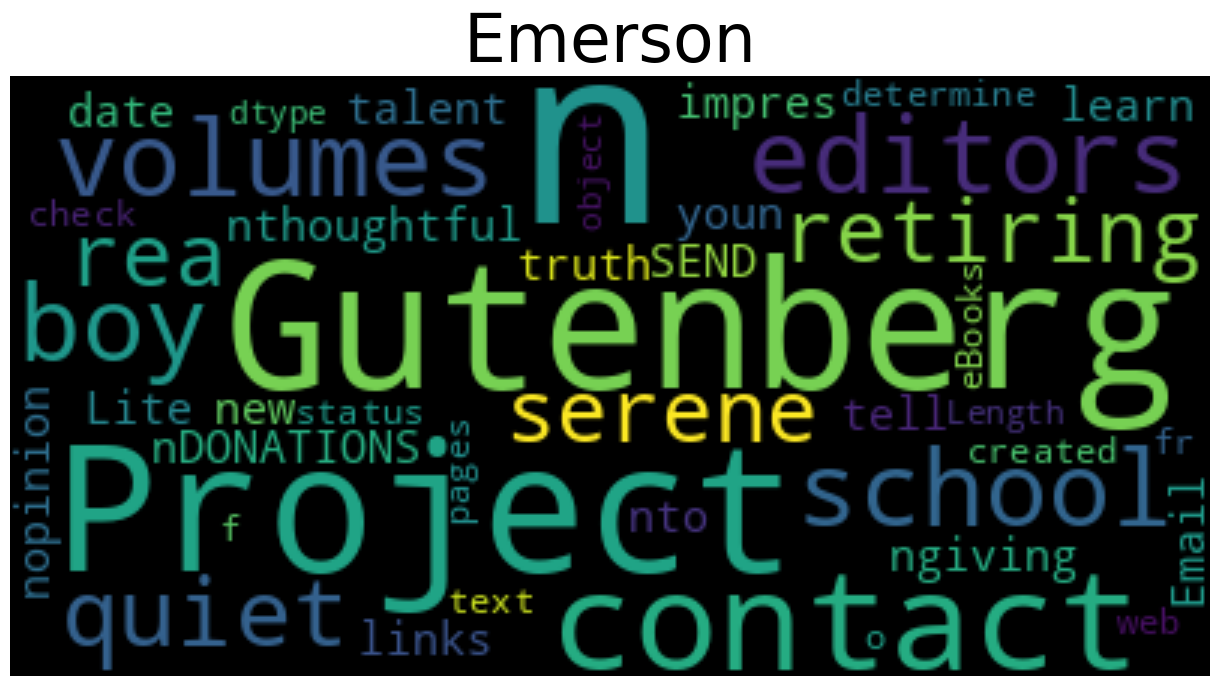

In [32]:
plot_word_cloud(emerson_df["text"], "Emerson")

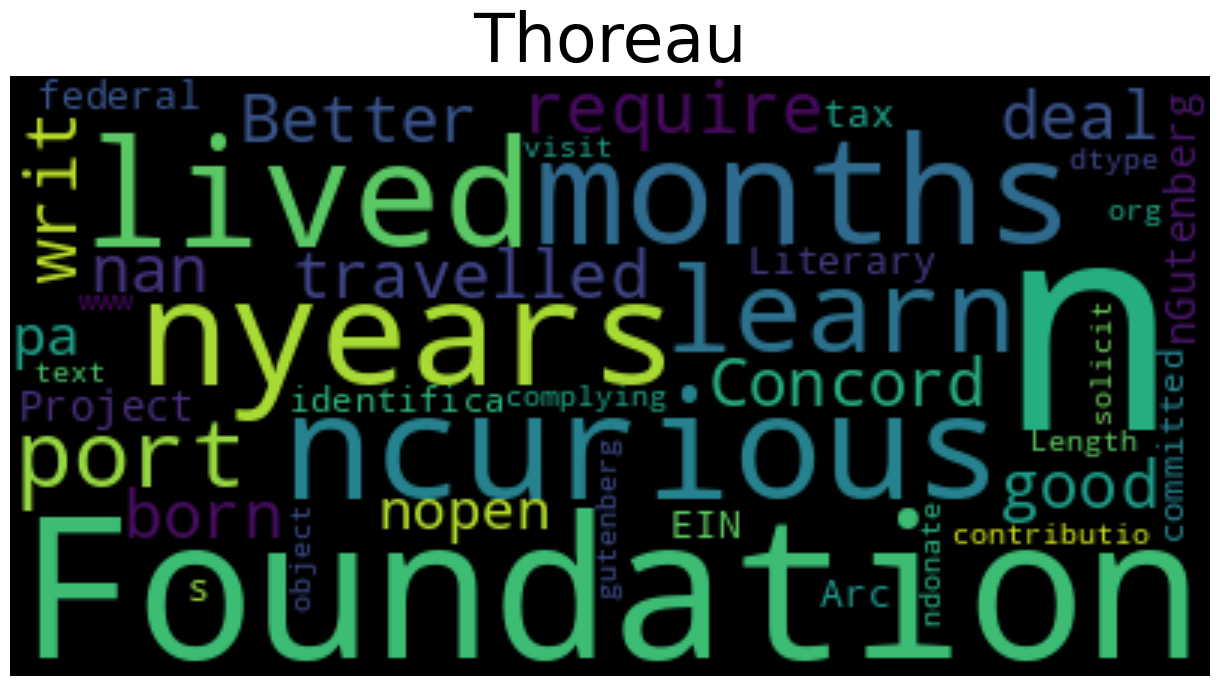

In [33]:
plot_word_cloud(thoreau_df["text"], "Thoreau")

In [34]:
# Preprocess text to remove stopwords, and perform lemmatization.

final_text = []
for index,entry in enumerate(combined_df['text']):
  doc = nlp(entry.lower())
  Final_words = []
  for word in doc:
    if not word.is_stop and not word.is_punct:
      Final_words.append(word.lemma_)
  final_text.append(' '.join(Final_words))



In [35]:
combined_df['final_text'] = final_text
combined_df.head()

,text,label,final_text
151,I look\n\nupon England to-day as an old gentle...,thoreau,look \n\n england day old gentleman travel gre...
638,Let us suck the sweetness of those affections ...,emerson,let suck sweetness affection \n\n consuetudes[...
63,From the cave we have advanced to roofs of\n\n...,thoreau,cave advance roof \n\n palm leave bark bough l...
409,"The result is now in question,\n\nalthough our...",emerson,result question \n\n word intimate popular fee...
35,"The soil, it appears, is suited to the seed, f...",thoreau,soil appear suit seed send \n\n radicle downwa...


In [36]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(combined_df["final_text"])
y = combined_df["label"]


In [37]:
# split our data into train and test sets.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4909)
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (1535, 11777)
y_train: (1535,)
x_test: (384, 11777)
y_test: (384,)


In [38]:
from sklearn.linear_model import LogisticRegression


In [39]:
# -2 for n_jobs is all but one CPU available.
lr_model = LogisticRegression(solver='saga', random_state=8102, n_jobs=-2)

lr_model.fit(x_train, y_train)

LogisticRegression(n_jobs=-2, random_state=8102, solver='saga')

In [40]:
y_pred = lr_model.predict(x_test)

In [41]:
from sklearn.metrics import f1_score

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import Markdown, display

def show_metrics(y_test, y_pred, model_name):
  display(Markdown(f"# {model_name}"))

  print(classification_report(y_test,y_pred))
  print("Test accuracy:", accuracy_score(y_test,y_pred))
  cm = confusion_matrix(y_test, y_pred)

  labels = ["emerson", "thoreau"]
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

# Logistic Regression

              precision    recall  f1-score   support

     emerson       0.86      0.93      0.90       220
     thoreau       0.90      0.80      0.85       164

    accuracy                           0.88       384
   macro avg       0.88      0.87      0.87       384
weighted avg       0.88      0.88      0.88       384

Test accuracy: 0.8776041666666666


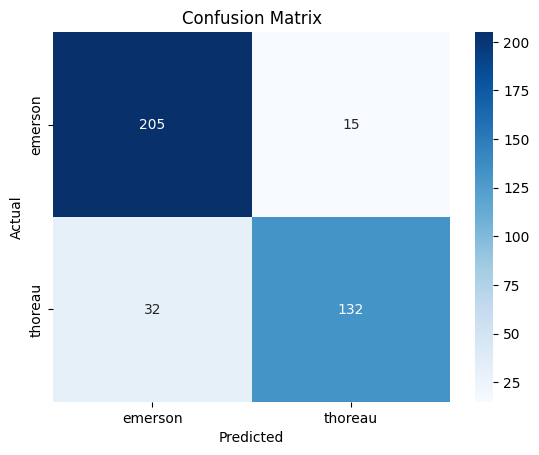

In [43]:
show_metrics(y_test, y_pred, "Logistic Regression")

In [44]:
# Let's compare that to random forests.


from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train,y_train)


RandomForestClassifier()

In [45]:
y_pred_rf = rf.predict(x_test)

# Random Forest

              precision    recall  f1-score   support

     emerson       0.85      0.90      0.87       220
     thoreau       0.86      0.78      0.82       164

    accuracy                           0.85       384
   macro avg       0.85      0.84      0.85       384
weighted avg       0.85      0.85      0.85       384

Test accuracy: 0.8515625


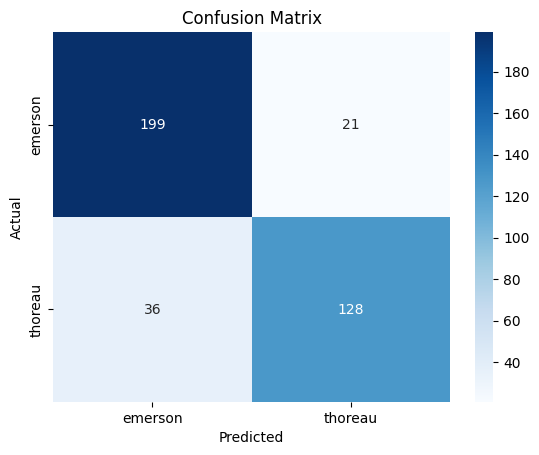

In [46]:
show_metrics(y_test, y_pred_rf, "Random Forest")

In [47]:
from sklearn import svm

In [48]:
# create the SVM classifier
clf = svm.SVC(kernel='rbf')

clf.fit(x_train,y_train)
clf

SVC()

In [49]:
y_pred_svm = clf.predict(x_test)

# SVM

              precision    recall  f1-score   support

     emerson       0.88      0.93      0.91       220
     thoreau       0.90      0.83      0.86       164

    accuracy                           0.89       384
   macro avg       0.89      0.88      0.88       384
weighted avg       0.89      0.89      0.89       384

Test accuracy: 0.8880208333333334


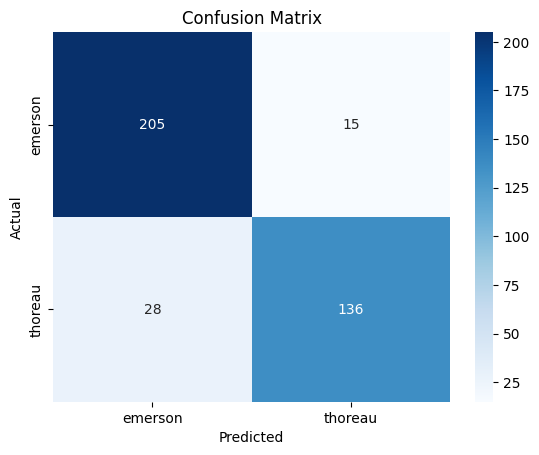

In [50]:
show_metrics(y_test, y_pred_svm, "SVM")

In [51]:
%pip install -q transformers

In [52]:
%pip install -q torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.0 MB/s eta 0:00:00


In [53]:
import torch

In [54]:
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [55]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", return_token_type_ids = False, padding="max_length", truncation=True)

model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [56]:
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(combined_df["text"], combined_df["label"], test_size=0.2, random_state=4909)
print(f"x_train_s: {x_train_s.shape}")
print(f"y_train_s: {y_train_s.shape}")
print(f"x_test_s: {x_test_s.shape}")
print(f"y_test_s: {y_test_s.shape}")


x_train_s: (1535,)
y_train_s: (1535,)
x_test_s: (384,)
y_test_s: (384,)


In [57]:
x_train_tok = tokenizer(x_train_s.tolist(), padding=True, truncation=True, return_tensors="pt")
y_train_tok = y_train_s.tolist()

x_test_tok = tokenizer(x_test_s.tolist(), padding=True, truncation=True, return_tensors="pt")
y_test_tok = y_test_s.tolist()


In [58]:
x_train_tok[0:2]

[Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [59]:

print(x_train_tok.keys())


#move onto device (GPU)
x_train_tok = {k:torch.tensor(v).to(device) for k,v in x_train_tok.items()}
x_test_tok = {k:torch.tensor(v).to(device) for k,v in x_test_tok.items()}

dict_keys(['input_ids', 'attention_mask'])


<ipython-input-59-cbedc1b8b59f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tok = {k:torch.tensor(v).to(device) for k,v in x_train_tok.items()}
<ipython-input-59-cbedc1b8b59f>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tok = {k:torch.tensor(v).to(device) for k,v in x_test_tok.items()}


In [60]:
with torch.no_grad():
  hidden_train = model(**x_train_tok)
  hidden_test = model(**x_test_tok)

# Get the [CLS] hidden states
cls_train = hidden_train.last_hidden_state[:,0,:]
cls_test = hidden_test.last_hidden_state[:,0,:]

In [61]:
x_train_db = cls_train.to("cpu")
# y_train_tok

x_test_db = cls_test.to("cpu")
# y_test_tok


In [62]:
lr_model2 = LogisticRegression(C=1, solver='saga', random_state=8102, n_jobs=-2, max_iter=10_000)

lr_model2.fit(x_train_db,y_train_tok)

# This does not converge, with the settings used for TF-DF
# ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
# So we adjusting max_iter and experimented with C (regulation strength).

y_pred = lr_model2.predict(x_test_db)


# Logistic Regression on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.94      0.94      0.94       220
     thoreau       0.92      0.92      0.92       164

    accuracy                           0.93       384
   macro avg       0.93      0.93      0.93       384
weighted avg       0.93      0.93      0.93       384

Test accuracy: 0.9296875


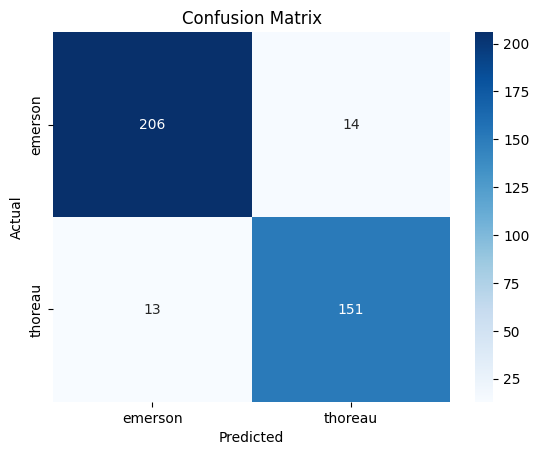

In [63]:
show_metrics(y_test_tok, y_pred, "Logistic Regression on DistilBERT hidden states")

In [64]:
rf = RandomForestClassifier()
rf.fit(x_train_db,y_train_tok)

rf.score(x_test_db,y_test_tok)

y_pred_rf = rf.predict(x_test_db)

# Random Forest on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.88      0.93      0.90       220
     thoreau       0.90      0.84      0.86       164

    accuracy                           0.89       384
   macro avg       0.89      0.88      0.88       384
weighted avg       0.89      0.89      0.89       384

Test accuracy: 0.8880208333333334


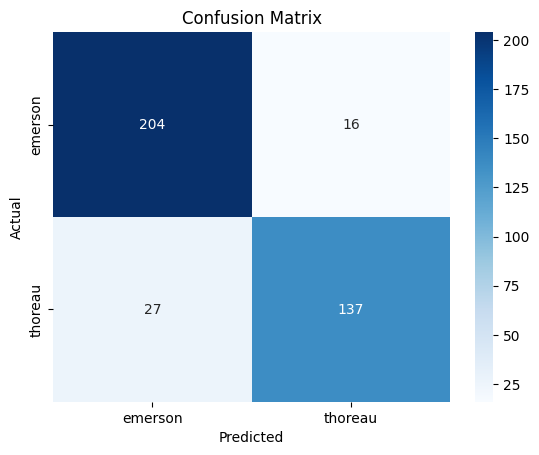

In [65]:
show_metrics(y_test_tok, y_pred_rf, "Random Forest on DistilBERT hidden states")

In [66]:
from sklearn import svm

In [67]:
# create the SVM classifier
clf = svm.SVC(kernel='rbf')

clf.fit(x_train_db,y_train_tok)

y_pred_svm = clf.predict(x_test_db)

# SVM on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.91      0.95      0.93       220
     thoreau       0.93      0.87      0.90       164

    accuracy                           0.92       384
   macro avg       0.92      0.91      0.92       384
weighted avg       0.92      0.92      0.92       384

Test accuracy: 0.9192708333333334


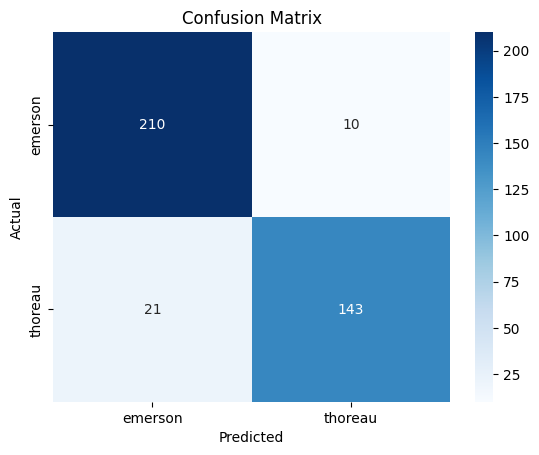

In [68]:
show_metrics(y_test_tok, y_pred_svm, "SVM on DistilBERT hidden states")

In [69]:
from transformers import DistilBertForSequenceClassification

# Define the model with random weights, suitable for binary classification (2 classes)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2
)
# we already have the appropriate tokenizer from before.



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
# create our optimizer
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [71]:
!pip install -q datasets

In [72]:
from sklearn import preprocessing

# Create a copy of our dataframe
trans_df = combined_df.copy()

# drop the preprocessed text column which we aren't using.
trans_df.drop("final_text", axis=1, inplace=True)

# transform our labels into numeric values.
le = preprocessing.LabelEncoder()
my_labels = trans_df["label"].tolist()
le.fit(my_labels)

my_cat_labels = le.classes_
trans_df["label"] = le.transform(trans_df["label"])

print(f"{my_cat_labels=}")

trans_df.info()
trans_df.describe()
trans_df.head()


my_cat_labels=array(['emerson', 'thoreau'], dtype='<U7')
<class 'pandas.core.frame.DataFrame'>
Index: 1919 entries, 151 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1919 non-null   object
 1   label   1919 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.0+ KB


,text,label
151,I look\n\nupon England to-day as an old gentle...,1
638,Let us suck the sweetness of those affections ...,0
63,From the cave we have advanced to roofs of\n\n...,1
409,"The result is now in question,\n\nalthough our...",0
35,"The soil, it appears, is suited to the seed, f...",1


In [73]:
from datasets import Dataset
from transformers import AutoTokenizer

# for simplicity, we are just splitting the dataset again.
train_df, test_df = train_test_split(trans_df, test_size=0.2, random_state=4909)



train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_data(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(tokenize_data, batched=True)
tokenized_test = test_dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/1535 [00:00<?, ? examples/s]

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

In [75]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    # this parameter was apparently removed recently.
    # evaluation_strategy="epoch",
    logging_strategy="epoch"
)

# Define Trainer object for training the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

<ipython-input-75-7e148adf619d>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ranton (ranton-fieldjay-com) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
192,0.379400
384,0.444100
576,0.170600
768,0.114900
960,0.093600


TrainOutput(global_step=960, training_loss=0.24051952362060547, metrics={'train_runtime': 83.6281, 'train_samples_per_second': 91.775, 'train_steps_per_second': 11.479, 'total_flos': 439982961599652.0, 'train_loss': 0.24051952362060547, 'epoch': 5.0})

In [76]:
# Save the model.
trainer.save_model('model')

In [77]:
# This is how you can load the model.

# from transformers import AutoModelForSequenceClassification
# model = AutoModelForSequenceClassification.from_pretrained("./model")

In [78]:
def predictor(text):
  #inputs = tokenizer(text, return_tensors="pt")
  inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}

  with torch.no_grad():
      logits = model(**inputs).logits
  predictions = torch.argmax(logits, dim=-1)
  return predictions


In [79]:
x_test_trans = test_dataset["text"]
y_test_trans = test_dataset["label"]

# sanity test a few inference inputs.
for txt, lbl in zip(x_test_trans[:5], y_test_trans[:5]):
  pred = predictor( txt)
  print(f"{my_cat_labels[lbl]}: pred={my_cat_labels[pred]}, {txt=}")

emerson: pred=emerson, txt='Let him\n\nnot peep or steal, or skulk up and down with the air of a charity-boy,\n\na bastard, or an interloper, in the world which exists for him. But\n\nthe man in the street, finding no worth in himself which corresponds\n\nto the force which built a tower or sculptured a marble god, feels\n\npoor when he looks on these. To him a palace, a statue, a costly book,\n\nhave an alien and forbidding air, much like a gay equipage, and seem\n\nto say like that, "Who are you, Sir?" Yet they all are his, suitors\n\nfor his notice, petitioners to his faculties that they will come out\n\nand take possession. The picture waits for my verdict: it is not to\n\ncommand me, but I am to settle its claims to praise.'
emerson: pred=emerson, txt="[Footnote 404: Mexico. The scene of Cortez's victories.]\n\n\n\n [Footnote 405: Marengo."
thoreau: pred=thoreau, txt='Yet so far are we from simplicity and independence\n\nthat, in Concord, fresh and sweet meal is rarely sold in the

<ipython-input-78-118abc29aba2>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}


In [80]:
y_pred_trans = [predictor(txt) for txt in x_test_trans]

for txt, lbl, pred in zip(x_test_trans[:5], y_test_trans[:5], y_pred_trans[:5]):
  print(f"{my_cat_labels[lbl]}: pred={my_cat_labels[pred]}, {txt=}")


<ipython-input-78-118abc29aba2>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}


emerson: pred=emerson, txt='Let him\n\nnot peep or steal, or skulk up and down with the air of a charity-boy,\n\na bastard, or an interloper, in the world which exists for him. But\n\nthe man in the street, finding no worth in himself which corresponds\n\nto the force which built a tower or sculptured a marble god, feels\n\npoor when he looks on these. To him a palace, a statue, a costly book,\n\nhave an alien and forbidding air, much like a gay equipage, and seem\n\nto say like that, "Who are you, Sir?" Yet they all are his, suitors\n\nfor his notice, petitioners to his faculties that they will come out\n\nand take possession. The picture waits for my verdict: it is not to\n\ncommand me, but I am to settle its claims to praise.'
emerson: pred=emerson, txt="[Footnote 404: Mexico. The scene of Cortez's victories.]\n\n\n\n [Footnote 405: Marengo."
thoreau: pred=thoreau, txt='Yet so far are we from simplicity and independence\n\nthat, in Concord, fresh and sweet meal is rarely sold in the

In [81]:
y_pred_trans = [torch.tensor(v).cpu() for v in y_pred_trans]

<ipython-input-81-29869180259a>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_trans = [torch.tensor(v).cpu() for v in y_pred_trans]


In [82]:
y_test_trans = [torch.tensor(v).cpu() for v in y_test_trans]

# Fine-tuned DistilBERT

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       214
           1       0.96      0.92      0.94       170

    accuracy                           0.95       384
   macro avg       0.95      0.95      0.95       384
weighted avg       0.95      0.95      0.95       384

Test accuracy: 0.9479166666666666


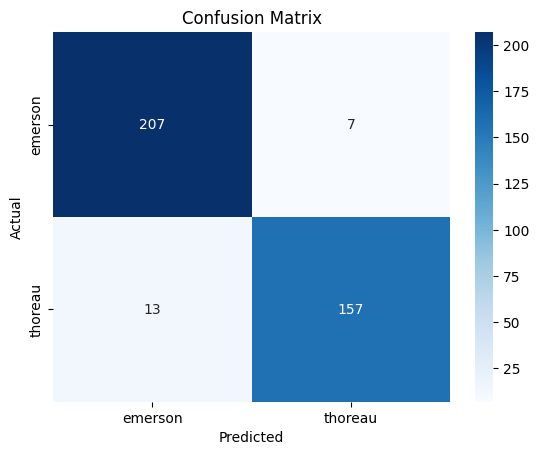

In [83]:
show_metrics(y_pred_trans, y_test_trans, "Fine-tuned DistilBERT")

## Let's check out the test samples that are misclassified.

In [84]:
def scalar_from_tensor(t):
  if t.dim() == 0:
    return t.item()
  elif t.dim() == 1:
    return t[0].item()
  else:
    raise ValueError(f"Unexpected tensor dimension: {t.dim()}")


In [85]:

y_test_trans = [scalar_from_tensor(t) for t in y_test_trans]
y_pred_trans = [scalar_from_tensor(t) for t in y_pred_trans]

print(f"y_test_trans: {y_test_trans[:5]}")
print(f"y_pred_trans: {y_pred_trans[:5]}")


y_test_trans: [0, 0, 1, 0, 0]
y_pred_trans: [0, 0, 1, 0, 0]


In [86]:
print("my_cat_labels")

rows = []
for i, (txt, lbl, pred) in enumerate(zip(x_test_trans, y_test_trans, y_pred_trans)):
  if lbl != pred:
    print(f"{lbl=},{pred=}")
    row =(my_cat_labels[lbl], my_cat_labels[pred], txt)
    print(f"{row=}")
    rows.append(row)

n_miss = len(rows)
print(f"Count of misclassified = {n_miss}")
misclassified_df = pd.DataFrame(rows, columns=["actual", "predicted", "text"])
misclassified_df.head(n_miss)


my_cat_labels
lbl=0,pred=1
row=(np.str_('emerson'), np.str_('thoreau'), 'The only joy I have in his being\n\nmine, is that the _not mine_ is _mine_. I hate, where I looked for a\n\nmanly furtherance, or at least a manly resistance, to find a mush of\n\nconcession. Better be a nettle in the side of your friend, than his\n\necho. The condition which high friendship demands is ability to do\n\nwithout it. That high office requires great and sublime parts.')
lbl=0,pred=1
row=(np.str_('emerson'), np.str_('thoreau'), 'Do not set the least value on what I do, or the least\n\ndiscredit on what I do not, as if I pretended to settle anything as\n\ntrue or false. I unsettle all things. No facts are to me sacred; none\n\nare profane; I simply experiment, an endless seeker with no Past at my\n\nback.\n\n\n\n')
lbl=0,pred=1
row=(np.str_('emerson'), np.str_('thoreau'), 'She arms\n\nand equips an animal to find its place and living in the earth, and,\n\nat the same time, she arms and equips another an

,actual,predicted,text
0,emerson,thoreau,"The only joy I have in his being\n\nmine, is t..."
1,emerson,thoreau,"Do not set the least value on what I do, or th..."
2,emerson,thoreau,She arms\n\nand equips an animal to find its p...
3,thoreau,emerson,The rays\n\nwhich stream through the shutter w...
4,thoreau,emerson,God himself culminates in the\n\npresent momen...
5,emerson,thoreau,"An orchard, good tillage, good grounds,\n\nsee..."
6,emerson,thoreau,"We will meet\n\nas though we met not, and part..."
7,emerson,thoreau,He is therefore\n\nlittle solicitous whence hi...
8,emerson,thoreau,"To have lived through all its sunny hours,\n\n..."
9,emerson,thoreau,"He is a carrion crow, and though you see not w..."


## Postscript - Few short learning with a modern LLM

Another technique that is used recently is to use a few-shot learning to inject examples as context into an existing LLM model.


In [104]:
# choose some examples of each author from our training set.
import re

training_df = combined_df.copy()

few_shot_num_examples = 10

thoreau_samples = training_df[ training_df["label"] == "thoreau"].sample(few_shot_num_examples, random_state=7809)
emerson_samples = training_df[ training_df["label"] == "emerson"].sample(few_shot_num_examples, random_state=997)

# remove the training samples.
training_df.drop(thoreau_samples.index, axis=0, inplace=True)
training_df.drop(emerson_samples.index, axis=0, inplace=True)

# print(f"Thoreau sample: {thoreau_samples}")
# print(f"Emerson sample: {emerson_samples}")

emerson_samples_array = emerson_samples['text'].to_list()
thoreau_samples_array = thoreau_samples['text'].to_list()

emerson_samples_array = [s.strip() for s in emerson_samples_array]
thoreau_samples_array = [s.strip() for s in thoreau_samples_array]

# replace multiple newlines with a single newline
emerson_samples_array = [re.sub(r'\n+', '\n', sample) for sample in emerson_samples_array]
thoreau_samples_array = [re.sub(r'\n+', '\n', sample) for sample in thoreau_samples_array]

print("======Emerson samples:======\n")
for idx, sample in enumerate(emerson_samples_array):
    print(f"{idx+1}: {sample}\n")

print("======Thoreau samples:======\n")
for idx, sample in enumerate(thoreau_samples_array):
    print(f"{idx+1}: {sample}\n")


======Emerson samples:======

1: John Hampden was an English statesman and
patriot who was killed in the civil war of the seventeenth century.]
 [Footnote 358: Colossus. The Colossus of Rhodes was a gigantic
statue--over a hundred feet in height--of the Rhodian sun god.

2: "--EMERSON, _Behavior_.]
 [Footnote 150: Plato (429-347 B.C.), (See note 36.)]
 [Footnote 151: Milton (1608-1674), the great English epic poet, author
of _Paradise Lost._
   "O mighty-mouth'd inventor of harmonies,
    O skill'd to sing of Time or Eternity,
    God-gifted organ-voice of England,
    Milton, a name to resound for ages."--TENNYSON.
]
 [Footnote 152: "The great poet makes feel our own wealth. "--EMERSON,
_The Over-Soul_.]

3: And
besides the general infusion of wit to heighten civility, the direct
splendor of intellectual power is ever welcome in fine society as the
costliest addition to its rule and its credit.
15. The dry light must shine in to adorn our festival, but it must be
tempered and shaded, 

In [132]:
# We also need our prompt template
prompt_template = """
You are an expert literary analyst. Your task is to classify whether a given text was written by {author1} or {author2}.

Here are some example texts from each author:

{author1} examples:
{author1_examples}

{author2} examples:
{author2_examples}

Based on these examples and your knowledge of their writing styles, analyze the following text and determine whether it was written by {author1} or {author2}:

Text to classify:
{text_to_classify}

Provide your classification and a brief explanation of your reasoning.
"""


In [106]:
def generate_prompt(text, author1, author2):
    prompt_text = prompt_template.format(author1=author1, author2=author2, author1_examples=emerson_samples_array, author2_examples=thoreau_samples_array, text_to_classify=text)
    return prompt_text


In [124]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

# Now that we have our samples, we can inject them into an LLM.
# we will use Hugging Face's transformers library to inject the samples into the model.


# this model is small but accepts longer input sequences than BERT/DistilBERT.
#model_name = "microsoft/Phi-3-mini-4k-instruct"
# model_name = "roberta-large"
model_name = "answerdotai/ModernBERT-base"

dev_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label={0: "emerson", 1: "thoreau"},
    label2id={"emerson": 0, "thoreau": 1}
    ).to(device)

# get the tokenizer for the model.
tokenizer = AutoTokenizer.from_pretrained(model_name)



config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [125]:
# Use the model to predict the samples.
import torch

def classify_text(text, author1, author2):
    prompt_text = generate_prompt(text, author1, author2)
    inputs = tokenizer(prompt_text, return_tensors="pt")
    inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()

    output_logits = outputs.logits
    predicted_class_id = torch.argmax(output_logits, dim=1).item()
    predicted_class_label = model.config.id2label[predicted_class_id]
    predicted_probability = torch.softmax(output_logits, dim=1).max().item()

    return predicted_class_label, predicted_probability

In [126]:
# let's try a few examples.

samples = training_df.sample(3, random_state=4909)

for cnt, (idx, sample) in enumerate(samples.iterrows()):
    print(f"Example {cnt+1}:")
    print(f"Text: {sample['text']}")
    predicted_label, predicted_probability = classify_text(sample['text'], "Emerson", "Thoreau")
    print(f"Prediction: {predicted_label} ({predicted_probability:.2f})")
    print(f"Actual: {sample['label']}")
    print("-" * 80)
    print("\n")

Example 1:
Text: [Footnote 556: Chaucer is a huge borrower. Taine, the French critic,

says on this subject: "Chaucer was capable of seeking out in the old

common forest of the Middle Ages, stories and legends, to replant them

in his own soil and make them send out new shoots.... He has the right

and power of copying and translating because by dint of retouching he

impresses ... his original work. He recreates what he imitates."]






<ipython-input-125-4388d3d376d9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:194: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Prediction: thoreau (0.65)
Actual: emerson
--------------------------------------------------------------------------------


Example 2:
Text: If you discover a

defect in this electronic work within 90 days of receiving it, you can

receive a refund of the money (if any) you paid for it by sending a

written explanation to the person you received the work from. If you

received the work on a physical medium, you must return the medium

with your written explanation. The person or entity that provided you

with the defective work may elect to provide a replacement copy in

lieu of a refund. If you received the work electronically, the person

or entity providing it to you may choose to give you a second

opportunity to receive the work electronically in lieu of a refund. If

the second copy is also defective, you may demand a refund in writing

without further opportunities to fix the problem.



1.F.4.
Prediction: thoreau (0.66)
Actual: emerson
----------------------------------------

<ipython-input-125-4388d3d376d9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}


Prediction: thoreau (0.65)
Actual: emerson
--------------------------------------------------------------------------------




In [ ]:
%pip install -q tqdm
from tqdm import tqdm


In [127]:
#A run over the whole dataset

# since we haven't trained the model, we don't really need to split the dataset.

MAX_SAMPLES = 100  # 100 samples is enough to get a good idea of the performance.

texts = training_df["text"].tolist()
y_actual_phi = training_df["label"].tolist()


# use tqdm to show progress
y_pred_phi = [classify_text(text, "Emerson", "Thoreau")[0] for text in tqdm(texts[:MAX_SAMPLES])]

y_actual_subset = y_actual_phi[:MAX_SAMPLES]
y_pred_subset = y_pred_phi


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-125-4388d3d376d9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}
100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


# Few shot learning

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     emerson       0.00      0.00      0.00        56
     thoreau       0.44      1.00      0.61        44

    accuracy                           0.44       100
   macro avg       0.22      0.50      0.31       100
weighted avg       0.19      0.44      0.27       100

Test accuracy: 0.44


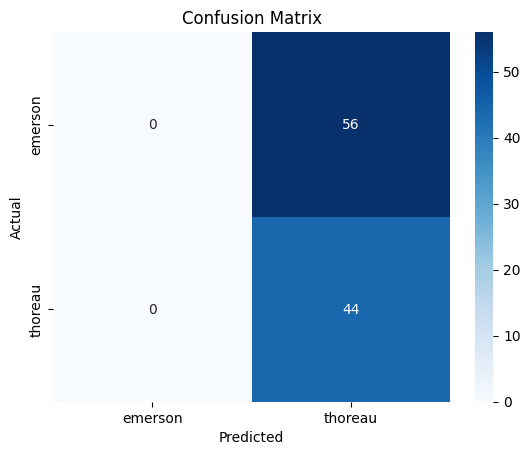

In [128]:
show_metrics(y_actual_subset, y_pred_subset, "Few shot learning")

In [129]:
# okay with langchain then

%pip install -q langchain

In [136]:
%pip install -q langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.1 MB/s eta 0:00:00


In [145]:
%pip install -q langchain_huggingface

In [137]:
from langchain.prompts import PromptTemplate

In [138]:
lc_prompt_template = PromptTemplate(
    input_variables=["author1", "author2", "author1_examples", "author2_examples", "text_to_classify"],
    template=prompt_template
)

In [146]:
from langchain_huggingface import HuggingFacePipeline

llm = HuggingFacePipeline.from_model_id(
    model_id="gpt2",
    task="text-generation",
    pipeline_kwargs={"max_new_tokens": 10},
)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cuda:0


In [153]:
for cnt, (idx, sample) in enumerate(samples.iterrows()):
    print(f"Example {cnt+1}:")
    print(f"Text: {sample['text']}")


    print(f"Text: {sample['text']}")
    print(f"Actual: {sample['label']}")

    print(dir(lc_prompt_template))
    prompt = lc_prompt_template.format(
          author1="emerson",
          author2="thoreau",
          author1_examples=emerson_samples_array,
          author2_examples=thoreau_samples_array,
          text_to_classify=sample['text']
      )

    predicted_label = llm.invoke(prompt)
    print(f"Prediction: {predicted_label}")

    print("-" * 80)
    print("\n")



Example 1:
Text: [Footnote 556: Chaucer is a huge borrower. Taine, the French critic,

says on this subject: "Chaucer was capable of seeking out in the old

common forest of the Middle Ages, stories and legends, to replant them

in his own soil and make them send out new shoots.... He has the right

and power of copying and translating because by dint of retouching he

impresses ... his original work. He recreates what he imitates."]




Text: [Footnote 556: Chaucer is a huge borrower. Taine, the French critic,

says on this subject: "Chaucer was capable of seeking out in the old

common forest of the Middle Ages, stories and legends, to replant them

in his own soil and make them send out new shoots.... He has the right

and power of copying and translating because by dint of retouching he

impresses ... his original work. He recreates what he imitates."]




Actual: emerson
['InputType', 'OutputType', '__abstractmethods__', '__add__', '__annotations__', '__class__', '__class_getitem_

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
